# Assignment 1 (part I): Line Fitting

## Problem 1
### Prove that affine transformations preserve parallel lines.

Solution:
Two parallel lines are lines in an affine plane which do not meet. Since affine transformations preserve planes and incidence, their images lie in an affine plane and do not meet. Hence they are parallel.

Let $l_1$ and $l_2$ be parallel lines through the points with position vector $\overrightarrow{p}$ and $\overrightarrow{q}$ respectfully. Let the direction of the line be that of $\overrightarrow{a}$. Then we have:
$$l_1 = \overrightarrow{p} + \lambda\overrightarrow{a}$$
$$l_2 = \overrightarrow{q} + \lambda\overrightarrow{a}$$

Now the images of the lines $l_1$ and $l_2$ under affine transformation $t(\overrightarrow{x}) = T\overrightarrow{x} + b$ are the sets:
$$t(l_1) = t(\overrightarrow{p}) + \lambda\ T\overrightarrow{a}$$
$$t(l_2) = t(\overrightarrow{q}) + \lambda\ T\overrightarrow{a}$$
Both of these lines have the same direction as that of $T\overrightarrow{a}$. Hence, the two lines under affine transform are parallel

## Problem 2 (least-squares)
### Complete implementation of function $estimate$ of class $LeastSquareLine$ below. It should update line parameters $a$ and $b$ correpsonding to line model $y=ax+b$. You can use either SVD of matrix $A$ or inverse of matrix $A^T A$, as discussed in class. NOTE: several cells below test your code.

In [30]:
%matplotlib notebook

import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt
from skimage.measure import ransac
import math

In [31]:
class LeastSquareLine:

    def __init__(self):
        self.a = 0.0
        self.b = 0.0
        
    def estimate(self, points2D):
        B = points2D[:,1]
        A = np.copy(points2D)
        A[:,1] = 1.0 

        # Vector B and matrix A are already defined. Change code below
        self.a = 0.0
        self.b = 0.0
        AT = np.transpose(A)
        AInv = la.inv(np.matmul(AT, A))
        B = np.matmul(AT, B)
        X = np.matmul(AInv, B)
        self.a = X[0]
        self.b = X[1]
        return True
        
    def predict(self, x): return (self.a * x) + self.b
    
    def predict_y(self, x): return (self.a * x) + self.b
            
    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])
    
    def line_par(self):
        return self.a, self.b

## Problem 3 (RANSAC for robust line fitting, single model)

#### Working code below generates a noisy cloud of points in ${\cal R}^2$ from a given line and a group of outliers.

<IPython.core.display.Javascript object>


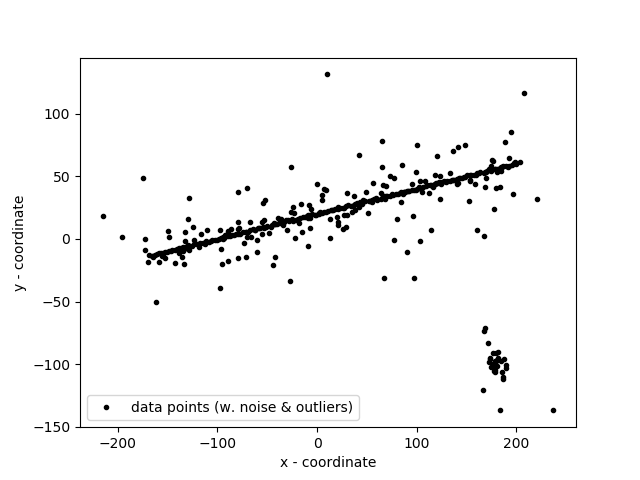

In [32]:
np.random.seed(seed=1)

# parameters for "true" line y = a*x + b
a, b = 0.2, 20.0

# x-range of points [x1,x2]
x_start, x_end = -200.0, 200.0

# generate the "true" line points
x = np.arange(x_start,x_end)
y = a * x + b               
data = np.column_stack([x, y])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data[:faulty.shape[0]] = faulty   # replacing the first 30 points in data with faulty (outliers)

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data += 0.5 * noise
data[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()


#### Code below uses your implementation of class $LeastSquareLine$ for least-square line fitting for the data above. The estimated line is displayed in the cell above. Use this cell to test your code in Problem 2. Of course, your least-square line will be affected by the outliers.

True
a:  0.048294529350927096
b:  12.455260549720043


<IPython.core.display.Javascript object>


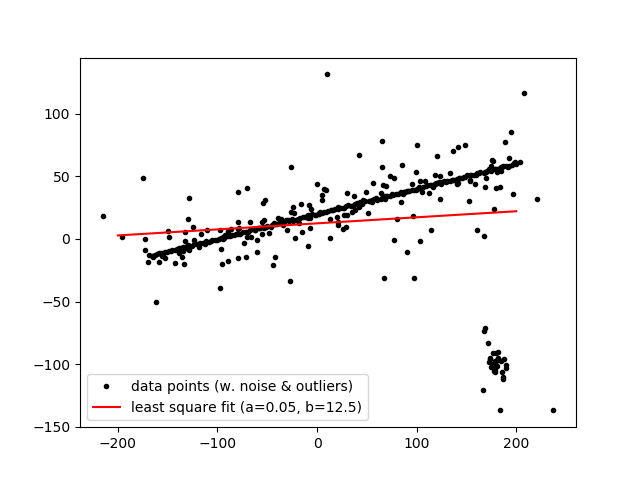

In [33]:
LSline = LeastSquareLine() # uses class implemented in Problem 2

print (LSline.estimate(data))
a_ls, b_ls = LSline.line_par()
print('a: ', a_ls)
print('b: ', b_ls)

# visualizing estimated line
fig, ax = plt.subplots()
ends = np.array([x_start,x_end])
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

### (part a) Assume that a set of $N=100$ points in $2D$ includes $N_i=20$ inliers for one line and $N_o=80$ outliers. What is the least number of times one should sample a random pair of points from the set to get probability $p\geq 0.95$ that in at least one of the sampled pairs both points are inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution: Lets define a few variables:

1. $\textbf{p}$: Probability that atleast one sample of points is an inliner
2. $\textbf{s}$: Number of samples
3. $\textbf{p_i}$: Probability of an inliner. $p_i = \frac{N_i}{N_i + N_o}$
4. $\textbf{p_o}$: Probability of an outlier. $p_o = 1 - p_i$
5. $\textbf{N}$: Number of iterations to get the desired probability

The probability is defined as: $p = 1 - (1 - p_i^s)^N$

Solving for N:

$(1 - p_i^s)^N = 1 - p$

$Nlog(1 - p_i^s) = log(1 - p)$

$N = \frac{log(1 - p)}{log(1 - p_i^s)} = \frac{log(1 - p)}{log(1 - (1 - p_o)^s)}$

In [34]:
def iterations(p, s, N_i, N_o):
    p_i = N_i / (N_i + N_o)
    return (math.log(1 - p)) / (math.log(1 - p_i ** s))

N = iterations(0.95, 2, 20, 80)
print('N =', N)
print('Number of trials:', math.ceil(N))

N = 73.38525000456701
Number of trials: 74


### (part b) Using the knowledge of the number of inliers/outliers in the example at the beginning of Problem 3, estimate the minimum number of sampled pairs needed to get RANSAC to "succeed" (to get at least one pair of inliers) with $p\geq 0.95$. Use your formula in part (a). Show your numbers in the cell below. Then, use your estimate as a value of parameter $max\text{_}trials$  inside function $ransac$ in the code cell below and test it.  You should also change $residual\text{_}threshold$ according to the noise level for inliers in the example. NOTE: the result is displayed in the same figure at the beginning of Problem 3.

Your estimates: N = 2
See code in the next cell for how function was called, and with the parameters 

N: 1.5479091113777612
Number of trials: 2
a: 0.1967934562944775 b: 20.098767358416517


<IPython.core.display.Javascript object>


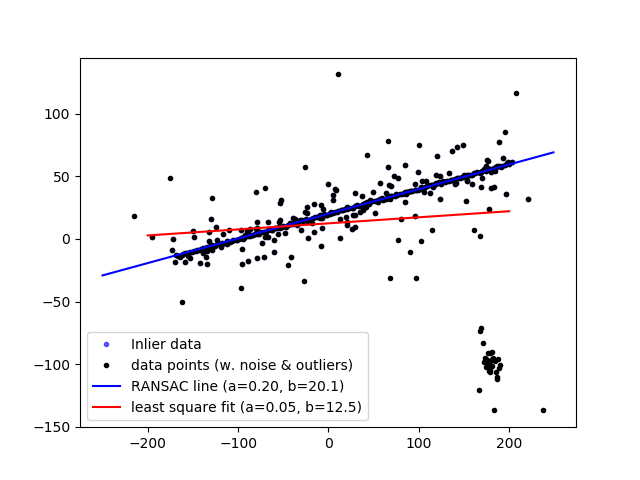

In [48]:
# robustly fit line using RANSAC algorithm
#I am assuming that the 30 points added a few cells above in the bottom are the outliers
N_i = len(data) - 30
N = iterations(0.95, 2, N_i, 30)
print('N:', N)
print('Number of trials:', math.ceil(N))

model_robust, inliers = ransac(data, LeastSquareLine, min_samples = 2, residual_threshold = 30, max_trials = math.ceil(N))
a_rs, b_rs = model_robust.line_par()
print('a:', a_rs, 'b:', b_rs)

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust.predict_y(line_x)

fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

## Problem 4 (sequential RANSAC for robust multi-line fitting)

#### Generating noisy data with outliers

<IPython.core.display.Javascript object>


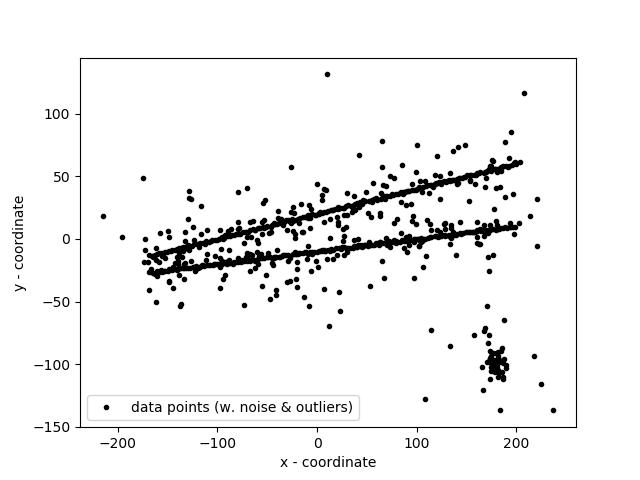

In [49]:
# parameters for "true" lines y = a*x + b
a2, b2 = 0.1, -10.0

# generate the "true" line points
y2 = a2 * x + b2
data2 = np.column_stack([x, y2])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data2[:faulty.shape[0]] = faulty   # replacing the first 30 points in data2 with faulty (outliers)

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data2+= 0.5 * noise
data2[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data2[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

dataSeq = np.concatenate((data,data2)) # combining with previous data

fig, ax = plt.subplots()
ax.plot(dataSeq[:,0], dataSeq[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

### Write code below using sequential RANSAC to detect two lines in the data above. Your lines should be displayed in the figure above.

N: 12.44699184162145
Number of trials: 13
Line 1 a: 0.10138391939204268 Line 1 b: -9.992592026178052
Line 2 a: 0.19786781669223918 Line 2 b: 20.239111475401717


<IPython.core.display.Javascript object>


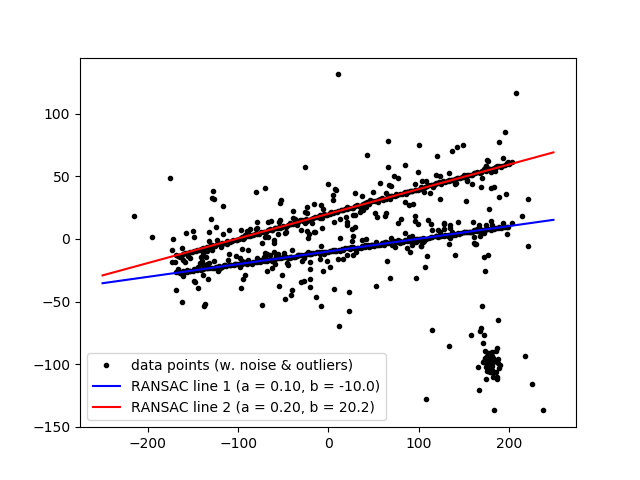

In [50]:
#I am assuming that the 30 points added a few cells above in the bottom are the outliers for both data set
#I am also assuming that of the remaining 770 points, half of them are outliers for each lines. so N_i = (800 - 60)/2
N_i = (len(dataSeq) - 60) / 2

N_o = len(dataSeq) - N_i
N = iterations(0.95, 2, N_i, N_o)
print('N:', N)
print('Number of trials:', math.ceil(N))

model_robust_1, inliers_1 = ransac(dataSeq, LeastSquareLine, min_samples = 2, residual_threshold = 3, max_trials = math.ceil(N))

line1_a_rs, line1_b_rs = model_robust_1.line_par()
print('Line 1 a:', line1_a_rs, 'Line 1 b:', line1_b_rs)

line_x_1 = np.arange(-250, 250)
line_y_robust_1 = model_robust_1.predict_y(line_x_1)

seqData = []

for i in range(len(data)):
    y = line1_a_rs * dataSeq[i][0] + line1_b_rs
    if (abs(y - dataSeq[i][1]) >= 20):
        seqData.append(dataSeq[i])

seqData = np.reshape(seqData, (len(seqData), 2))   

model_robust_2, inliers_2 = ransac(seqData, LeastSquareLine, min_samples = 2, residual_threshold = 3, max_trials = math.ceil(N))

line2_a_rs, line2_b_rs = model_robust_2.line_par()
print('Line 2 a:', line2_a_rs, 'Line 2 b:', line2_b_rs)

line_x_2 = np.arange(-250, 250)
line_y_robust_2 = model_robust.predict_y(line_x_2)

fig, ax = plt.subplots()
ax.plot(dataSeq[:,0], dataSeq[:,1], '.k', label = 'data points (w. noise & outliers)')
ax.plot(line_x_1, line_y_robust_1, '-b', label = 'RANSAC line 1 (a = {:4.2f}, b = {:4.1f})'.format(line1_a_rs, line1_b_rs))
ax.plot(line_x_2, line_y_robust_2, '-r', label = 'RANSAC line 2 (a = {:4.2f}, b = {:4.1f})'.format(line2_a_rs, line2_b_rs))
ax.legend(loc = 'lower left')
plt.show()